In [8]:
import scipy.stats as sps
import numpy as np

import pandas as pd
import math
import random
import sklearn

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

from libmf import mf

Данные, которые подаются на вход базовому алгоритму состоят из:
 - множества всех товаров на данной итерации,
 - множества всех пользователей,
 - таблица F формы (c_len, w_len) с фидбеком пользователей для товаров. фидбек $\in [0, 1]$


Данные генерируем синтетическим образом:
cчитаем, что пользователи имеют одну фичу и она распределена нормально:  $c_i
\sim \cal{N} (1.65,\ 0.2^2)$ . Товары задаются одной фичей, которая распределена равномерно: $w_i \sim \cal {U}(1, 2) $.
Фидбек будем генерировать так: $F_{c,w} = C[a_c + t_w + \varepsilon_{c, w}]$. Где
 $a_c \sim \cal{N}(0.6, 0.2^2) $ - центр оценки пользователя $c$, $t_w \sim \cal N(0,0.2^2)$ - полезность товара,  $\varepsilon \sim \cal N(0, 0.05^2)$ - случайный шум. C(x) - это функция, которая округляет фидбэк к отрезку $[0,1]$: \\
 если x > 1: C(x) =  1 \\
 если x < 0: C(x) = 0 \\
 иначе: C(x) = x


In [2]:
c_size = 100
w_size = 50

c_mean = 1.65
c_sigma = 0.2
c_distr = sps.norm(c_mean, c_sigma)
c_sample = c_distr.rvs(size=c_size)

w_params = [0, 1]
w_distr = sps.uniform(*w_params)
w_sample = w_distr.rvs(size=w_size)


In [3]:
centr = sps.norm(0.6, 0.2).rvs(size=c_size)
usefulness = sps.norm(0, 0.2).rvs(size=w_size)
epsilon = sps.norm(0, 0.05).rvs(size=(c_size, w_size))


In [5]:
Feedback = (epsilon + usefulness) + centr[:, np.newaxis]


Релизуем базовый алгоритм TopPop. Он не зависит от конкретного пользователя и рекомендует ему n товаров, с самым большим рейтингом.

In [255]:
def TopPop(X, n):
    # X: (c_len, w_len)
    indices = np.argpartition(np.mean(X, axis=0), n)[:n]
    # return value: nd.array indicies of recommended items, probability for every customer of buiyng recommended items.
    return indices, X[:, indices]

Ткт я решил все-так использовать MovieLens... Но можно попробовать и на синтетических потом
MovieLens 100K:
ContentBasedRecommender - рекоммендует товары, наиболее похожие на те, с которыми пользователь взаимодействовал до этого


In [4]:

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'item_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

Разобъем обучающую и тренеровочную выборки относительно времени:

In [5]:

ratings_train, ratings_test = train_test_split(ratings, test_size=0.1, shuffle=True)


In [54]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100


def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if person_id in interactions_df.index:
        interacted_items = interactions_df.loc[person_id]['item_id']
    else:
        return set()
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])


class ModelEvaluator:

    def __init__(self, ratings_train, ratings_test):
        self.ratings_train_indexed = ratings_train.set_index('user_id')
        self.ratings_test_indexed = ratings_test.set_index('user_id')

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, self.ratings_train_indexed)

        all_items = set(pd.concat((self.ratings_test_indexed['item_id'], self.ratings_train_indexed['item_id'])))

        non_interacted_items = all_items - interacted_items
        # random.seed(seed)
        # non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = self.ratings_test_indexed.loc[person_id]
        if type(interacted_values_testset['item_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['item_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['item_id'])])
        interacted_items_count_testset = len(person_interacted_items_testset)

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    self.ratings_train_indexed),
                                               topn=1000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                               sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                               seed=item_id % (2 ** 32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['item_id'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['item_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count': hits_at_5_count,
                          'hits@10_count': hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(self.ratings_test_indexed.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        # print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
            .sort_values('interacted_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(
            detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(
            detailed_results_df['interacted_count'].sum())

        global_metrics = {'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df


model_evaluator = ModelEvaluator(ratings_train, ratings_test)

In [55]:
from Popularity_Predictor import PopularityRecommender
popularity_recommender = PopularityRecommender(ratings_train)



Global metrics: {'recall@5': 0.009900990099009901, 'recall@10': 0.009900990099009901}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
9,0,0,4,0.0,0.0,85
55,0,0,4,0.0,0.0,239
11,0,0,3,0.0,0.0,222
29,0,0,3,0.0,0.0,7
70,0,0,3,0.0,0.0,13
41,0,0,3,0.0,0.0,279
8,0,0,2,0.0,0.0,109
53,0,0,2,0.0,0.0,197
51,0,0,2,0.0,0.0,313
58,0,0,2,0.0,0.0,303


In [6]:
from CF_Predictor import CFRecommender
cf_recommender_model = CFRecommender(ratings_train, movies)

In [7]:
cf_recommender_model.recommend_items(3, topn=10)

,item_id,rating
0,300,0.522111
1,333,0.497406
2,328,0.491479
3,302,0.476789
4,288,0.472172
5,268,0.454116
6,307,0.452877
7,313,0.447774
8,258,0.444505
9,340,0.435754


In [40]:
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:', cb_global_metrics)
cb_detailed_results_df.head(10)

68it [00:00, 461.28it/s]


Global metrics: {'recall@5': 0.04950495049504951, 'recall@10': 0.13861386138613863}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
35,0,1,3,0.0,0.333333,13
16,0,0,3,0.0,0.000000,279
1,0,0,3,0.0,0.000000,90
3,0,0,3,0.0,0.000000,293
8,0,0,3,0.0,0.000000,160
6,0,0,3,0.0,0.000000,250
23,0,0,3,0.0,0.000000,194
55,0,0,2,0.0,0.000000,268
43,0,0,2,0.0,0.000000,99
65,0,0,2,0.0,0.000000,130


In [41]:
from Random_Predictor import RandomRecommender
random_model = RandomRecommender(ratings_train)

68it [00:00, 853.26it/s]


Global metrics: {'recall@5': 0.019801980198019802, 'recall@10': 0.0297029702970297}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
35,0,0,3,0.0,0.0,13
16,0,0,3,0.0,0.0,279
1,0,0,3,0.0,0.0,90
3,0,0,3,0.0,0.0,293
8,0,0,3,0.0,0.0,160
6,0,0,3,0.0,0.0,250
23,0,0,3,0.0,0.0,194
55,0,0,2,0.0,0.0,268
43,0,0,2,0.0,0.0,99
65,0,0,2,0.0,0.0,130


In [107]:
def calc_metrics(evaluator, model):
    cf_global_metrics, _ = evaluator.evaluate_model(model)
    return cf_global_metrics['recall@5'], cf_global_metrics['recall@10']

In [108]:
num_of_steps = 1000

len_of_new_data = ratings.shape[0] / num_of_steps

results = {
    "CF": [],
    "Random": [],
    "PopTop": []
}

for i in tqdm(range(1, num_of_steps)):
    
    ratings_train = ratings.loc[:len_of_new_data * i]
    ratings_test = ratings.loc[len_of_new_data * i: len_of_new_data * (i + 1)]
    model_evaluator = ModelEvaluator(ratings_train, ratings_test)
    results["CF"].append(calc_metrics(model_evaluator, CFRecommender(ratings_train, movies)))
    results["Random"].append(calc_metrics(model_evaluator, RandomRecommender(ratings_train)))
    results["PopTop"].append(calc_metrics(model_evaluator, PopularityRecommender(ratings_train)))


  3%|▎         | 30/999 [00:17<09:17,  1.74it/s]


KeyboardInterrupt: 

In [77]:
def print_mectics(name, results, ax):
    res = np.array(results[name]).T
    ax.set_ylim((0, 0.5))
    
    ax.plot(np.arange(1, num_of_steps), res[0], label='recall@5')
    ax.plot(np.arange(1, num_of_steps), res[1], label='recall@10')
    ax.set_title(name)
    ax.set_xlabel("iteration")
    ax.legend()

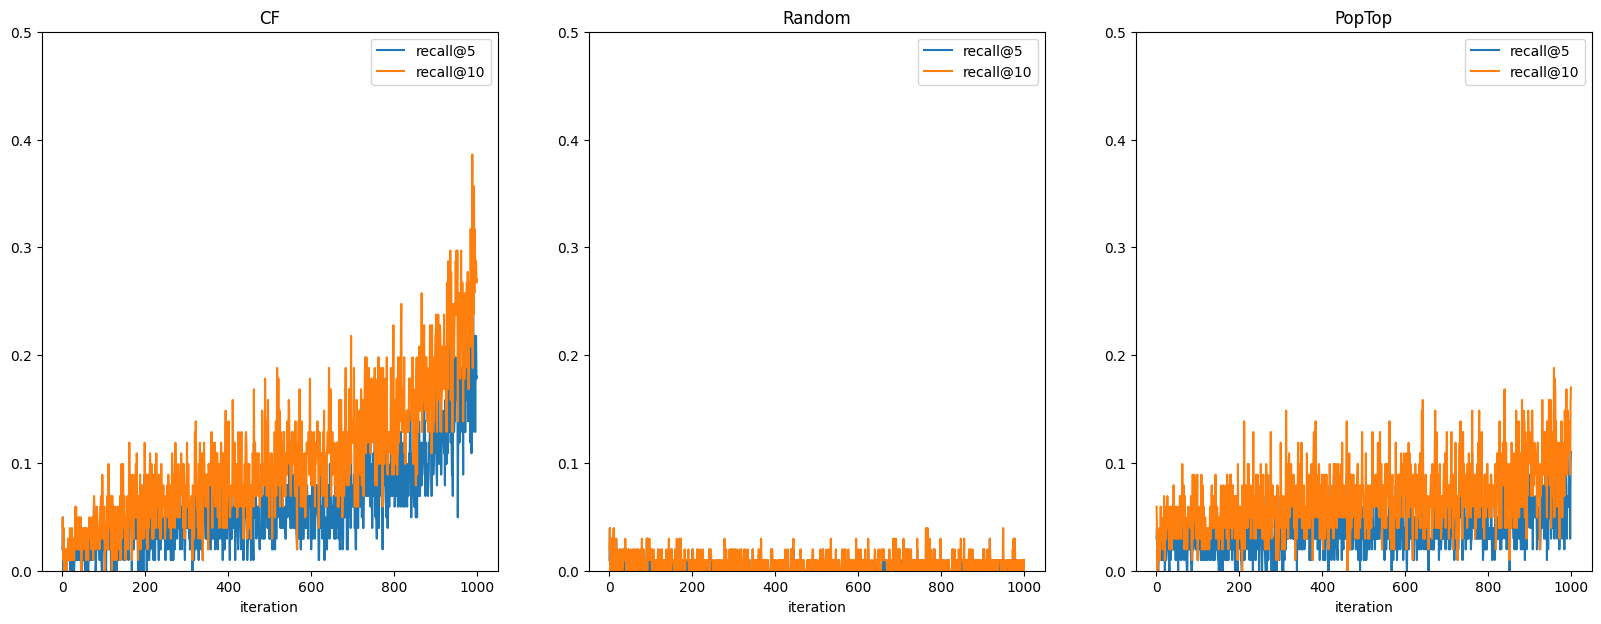

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

print_mectics("CF", results, axs[0])
print_mectics("Random", results, axs[1])
print_mectics("PopTop", results, axs[2])
